# import

In [10]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import Dense
import random
from collections import deque
env = gym.make("MountainCar-v0")

#  data

In [11]:
memory_max = 50000
memory_min = 1000
batchsize = 64
gama = 0.99
episodes = 7000
epsilon = 1
epsilon_step = 0.003
epsilon_min = 0.001

ep_rewards = []

update_timer = 5

# simple net

In [12]:
# 输入状态输出动作
def simple_net():
    model = Sequential([
        Dense(16, input_shape=(env.observation_space.shape), activation='relu'),
        Dense(16, activation='relu'),
        Dense(env.action_space.n)
    ])
    model.compile(optimizer = 'adam',
                  loss = 'mse',
                  metrics = ['accuracy'])
    return model


# DQN

In [13]:
class DQN:
    
    def __init__(self):
        
        self.memory = deque(maxlen = memory_max)
        # part1
        # prediction_model和s得到Q表
        # part2
        # target_model和s'得到Q'表，求出最大的Q_max
        # 用Q_max让神经网络学习,更新prediction_model
        # part3
        # 隔一定的轮次后把prediction_model的参数赋给target_model
        self.prediction_model = simple_net()
        self.target_model = simple_net()
        self.target_model.set_weights(self.prediction_model.get_weights())
        
        self.timer = 0
        
    def get_from_QTable(self, state):
        temp = np.array(state)
        temp = temp.reshape(-1, *state.shape)
        return self.prediction_model.predict(temp)[0]
        
    def train(self, done):
        if len(self.memory) < memory_min:
            return
        # 要记录数据用以训练网络
        x_train = []
        y_train = []
        # part1
        batch = random.sample(self.memory, batchsize)
        states1 = np.array([sample[0] for sample in batch])
        QTable1 = self.prediction_model.predict(states1)
        # part2
        states2 = np.array([sample[3] for sample in batch])
        QTable2 = self.target_model.predict(states2)
        for index, (current_state, action, reward, next_state, done) in enumerate(batch):
            if not done:
                Qmax = np.max(QTable2[index])
                new_q = reward + gama * Qmax
            else:
                new_q = reward
            QTable1[index][action] = new_q     
            x_train.append(current_state)
            y_train.append(QTable1[index])
        self.prediction_model.fit(np.array(x_train), np.array(y_train), batch_size=batchsize, verbose = 0)
        # part3
        if done:
            self.timer += 1
        if self.timer >= update_timer:
            self.target_model.set_weights(self.prediction_model.get_weights())
            self.timer = 0
myDQN = DQN()

# Training

In [15]:
ep_rewards_recorder = {'ep':[],'avg':[],'min':[],'max':[]}
for episode in range(episodes):
    ep_reward = 0;
    step = 0;
    current_state = env.reset()
    done = False
    while not done:
        if np.random.random() > epsilon:
            action = np.argmax(myDQN.get_from_QTable(current_state))
        else:
            action = np.random.randint(0, env.action_space.n)
        next_state, reward, done, _ = env.step(action)
        ep_reward += reward
        
        myDQN.memory.append((current_state, action, reward, next_state, done))
        # print("len_memory:{}".format(len(myDQN.memory))) 
        myDQN.train(done)
        current_state = next_state
        step += 1
    ep_rewards.append(ep_reward)
    if episode == 0:
        ep_rewards_recorder['ep'].append(episode)
        ep_rewards_recorder['avg'].append(-200)
        ep_rewards_recorder['min'].append(-200)
        ep_rewards_recorder['max'].append(-200)
        print(episode)
    elif not episode % 50:
        ep_rewards_recorder['ep'].append(episode)
        ep_rewards_recorder['avg'].append(sum(ep_rewards[-50:])/50)
        ep_rewards_recorder['min'].append(min(ep_rewards[-50:]))
        ep_rewards_recorder['max'].append(max(ep_rewards[-50:]))
        print(episode)
    if epsilon > epsilon_min:
        epsilon -= epsilon_step

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950


# Plot

Text(0,0.5,'Rewards')

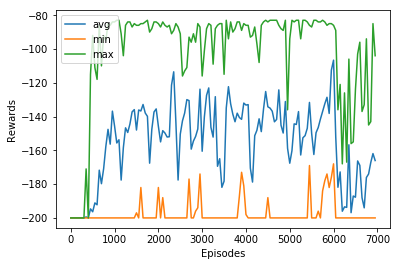

In [16]:
plt.plot(ep_rewards_recorder['ep'], ep_rewards_recorder['avg'], label = 'avg')
plt.plot(ep_rewards_recorder['ep'], ep_rewards_recorder['min'], label = 'min')
plt.plot(ep_rewards_recorder['ep'], ep_rewards_recorder['max'], label = 'max')
plt.legend(loc='upper left')
plt.xlabel('Episodes')
plt.ylabel('Rewards')

# Rendering

In [17]:
done = False
state = env.reset()
step = 0
while not done:
    step += 1
    action = np.argmax(myDQN.get_from_QTable(state))
    next_state, _, done, _ = env.step(action)
    state = next_state
    env.render()
env.close()
print("use {} steps to achieve the goal".format(step))

use 153 steps to achieve the goal
